In [1]:
# Change working directory
%cd ..

d:\HUST\OT factorization\ot-kpgf


In [2]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Disable warnings
import warnings
warnings.filterwarnings('ignore')

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import json
import pandas as pd
import numpy as np
import scipy
import os
import ot
from optimal_transport.models import KeypointFOT, FOT, LOT, EMD
from optimal_transport.experiments import OutlierRate, ClusterMismatch, Dimensionality
from typing import Tuple, Optional, List, Union, Dict

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
import seaborn as sns

Dimension: 5, Accuracy: {'KeypointFOT': 0.5975, 'FOT': 0.155, 'LOT': 0.2175, 'OT': 0.2225}, Runtime: {'KeypointFOT': 21.85243272781372, 'FOT': 11.829943180084229, 'LOT': 0.1338202953338623, 'OT': 0.03818225860595703}
Dimension: 10, Accuracy: {'KeypointFOT': 0.5475, 'FOT': 0.1725, 'LOT': 0.2375, 'OT': 0.2025}, Runtime: {'KeypointFOT': 22.173542261123657, 'FOT': 15.749060869216919, 'LOT': 0.17922711372375488, 'OT': 0.04553103446960449}
Dimension: 15, Accuracy: {'KeypointFOT': 0.515, 'FOT': 0.1625, 'LOT': 0.225, 'OT': 0.195}, Runtime: {'KeypointFOT': 21.3795964717865, 'FOT': 28.45473337173462, 'LOT': 0.21670079231262207, 'OT': 0.06521964073181152}
Dimension: 20, Accuracy: {'KeypointFOT': 0.555, 'FOT': 0.16, 'LOT': 0.2325, 'OT': 0.2075}, Runtime: {'KeypointFOT': 24.200099229812622, 'FOT': 8.88725733757019, 'LOT': 0.24058127403259277, 'OT': 0.05872535705566406}
Dimension: 25, Accuracy: {'KeypointFOT': 0.5425, 'FOT': 0.16, 'LOT': 0.2275, 'OT': 0.19}, Runtime: {'KeypointFOT': 28.6320433616638

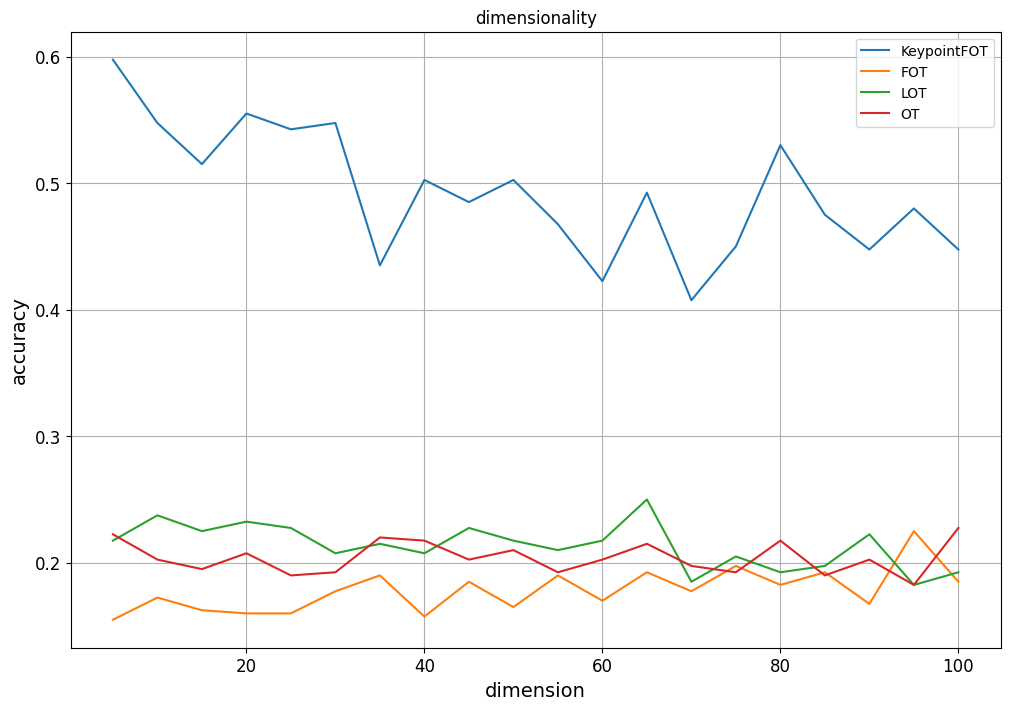

In [3]:
#@title Dimensionality
n_anchors = 4
n_keypoints = 4
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, 5-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = Dimensionality(model=models, log_dir="logs")
results = experiment(noise_level=0.5, max_projected_dim=100, freq_projected_dim=5, hyperplane_dim=5,
                     n_components=k, cluster_samples=100, n_keypoints=n_keypoints, 
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                     )

Noise ratio: 0.0, Accuracy: {'KeypointFOT': 0.9975, 'FOT': 0.49, 'LOT': 0.405, 'OT': 0.355}, Runtime: {'KeypointFOT': 0.7919020652770996, 'FOT': 8.503978967666626, 'LOT': 0.31695008277893066, 'OT': 0.07010579109191895}
Noise ratio: 0.1, Accuracy: {'KeypointFOT': 0.9925, 'FOT': 0.49, 'LOT': 0.415, 'OT': 0.3575}, Runtime: {'KeypointFOT': 0.8279476165771484, 'FOT': 3.8483760356903076, 'LOT': 0.4930415153503418, 'OT': 0.11005687713623047}
Noise ratio: 0.2, Accuracy: {'KeypointFOT': 0.9925, 'FOT': 0.48, 'LOT': 0.4, 'OT': 0.375}, Runtime: {'KeypointFOT': 0.810084342956543, 'FOT': 2.643871545791626, 'LOT': 0.2832624912261963, 'OT': 0.06296491622924805}
Noise ratio: 0.30000000000000004, Accuracy: {'KeypointFOT': 0.985, 'FOT': 0.49, 'LOT': 0.355, 'OT': 0.36}, Runtime: {'KeypointFOT': 1.74403715133667, 'FOT': 8.886166334152222, 'LOT': 0.28059840202331543, 'OT': 0.06403326988220215}
Noise ratio: 0.4, Accuracy: {'KeypointFOT': 0.9875, 'FOT': 0.4975, 'LOT': 0.4275, 'OT': 0.3675}, Runtime: {'Keypoin

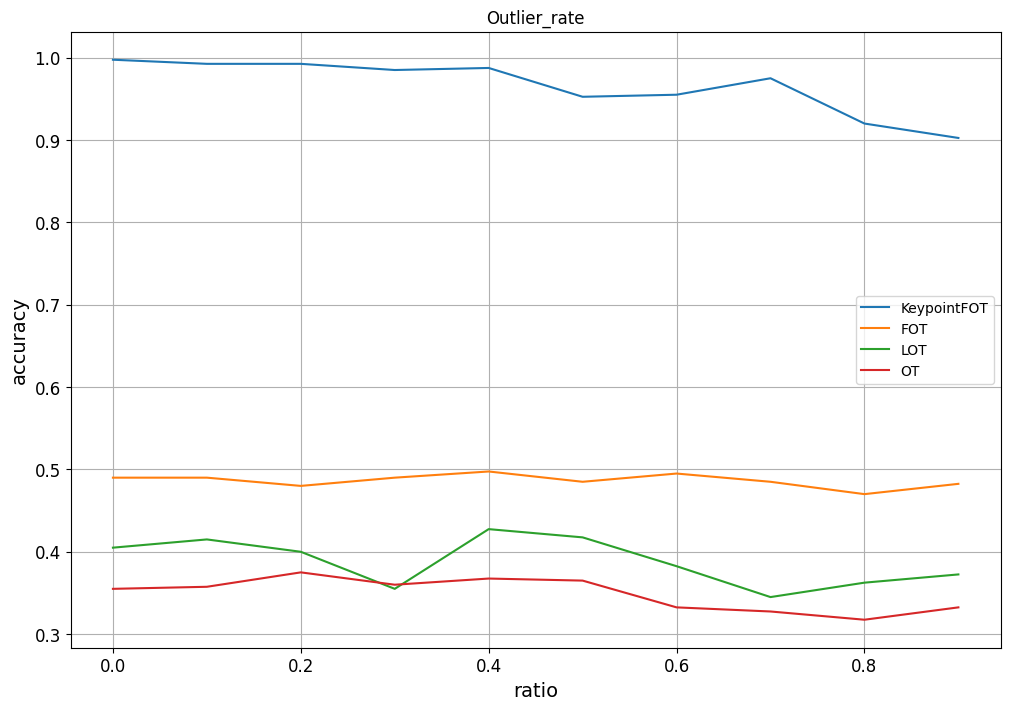

In [4]:
#@title Outlier rate
n_anchors = 4
n_keypoints = 4
d = 30
k = 4
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = OutlierRate(model=models, log_dir="logs")
results = experiment(max_noise_ratio=1, freq_noise_ratio=0.1, hyperplane_dim=d, 
                     cluster_samples=100, n_keypoints=n_keypoints, n_components=k,
                     src_properties={"means": mean_s, "cov_scale": 0.1},
                     trg_properties={"means": mean_t, "cov_scale": 0.1}
                    )

Number of source components: 2, Accuracy: {'KeypointFOT': 0.045, 'FOT': 0.06, 'LOT': 0.0, 'OT': 0.125}, Runtime: {'KeypointFOT': 1.3536286354064941, 'FOT': 9.623733758926392, 'LOT': 0.3678872585296631, 'OT': 0.07536005973815918}
Number of source components: 3, Accuracy: {'KeypointFOT': 0.09666666666666666, 'FOT': 0.11, 'LOT': 0.0, 'OT': 0.17}, Runtime: {'KeypointFOT': 2.921428918838501, 'FOT': 8.828391075134277, 'LOT': 0.45829200744628906, 'OT': 0.11152029037475586}
Number of source components: 4, Accuracy: {'KeypointFOT': 0.12, 'FOT': 0.12, 'LOT': 0.01, 'OT': 0.205}, Runtime: {'KeypointFOT': 1.4369893074035645, 'FOT': 5.5153892040252686, 'LOT': 0.5705435276031494, 'OT': 0.13698053359985352}
Number of source components: 5, Accuracy: {'KeypointFOT': 0.312, 'FOT': 0.244, 'LOT': 0.098, 'OT': 0.236}, Runtime: {'KeypointFOT': 2.777768850326538, 'FOT': 4.234612703323364, 'LOT': 0.6660494804382324, 'OT': 0.16746902465820312}
Number of source components: 6, Accuracy: {'KeypointFOT': 0.40166666

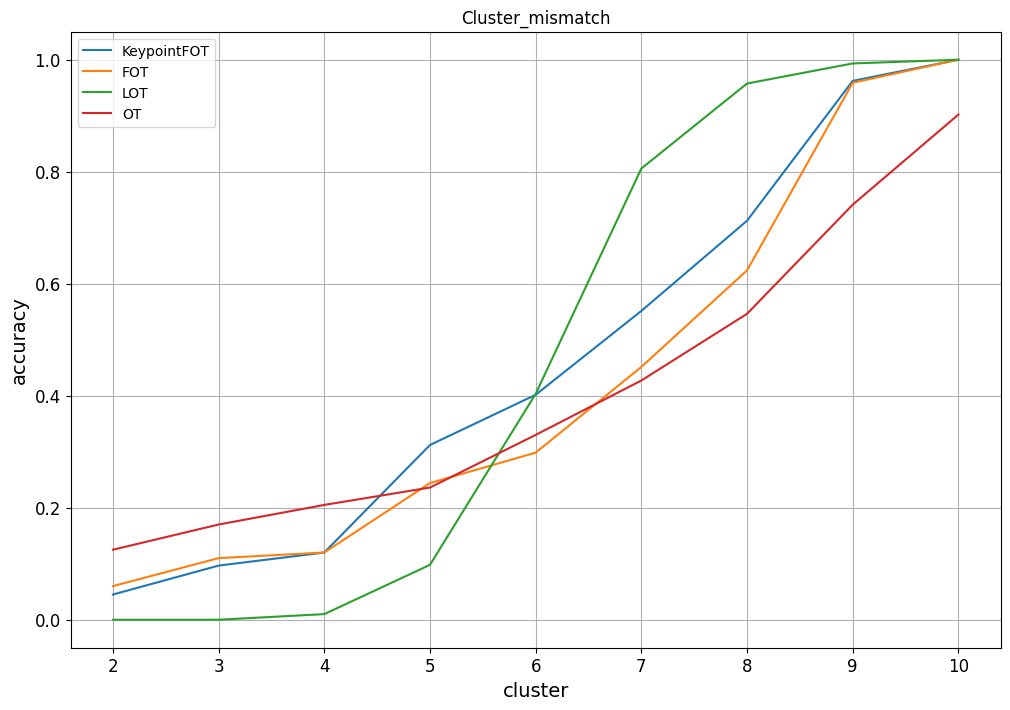

{'KeypointFOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.045,
   0.09666666666666666,
   0.12,
   0.312,
   0.40166666666666667,
   0.5514285714285714,
   0.7125,
   0.9622222222222222,
   1.0],
  'runtime': [1.3536286354064941,
   2.921428918838501,
   1.4369893074035645,
   2.777768850326538,
   3.053947925567627,
   3.0071215629577637,
   2.896373987197876,
   3.683518648147583,
   3.7623138427734375]},
 'FOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.06,
   0.11,
   0.12,
   0.244,
   0.29833333333333334,
   0.4514285714285714,
   0.62375,
   0.9588888888888889,
   1.0],
  'runtime': [9.623733758926392,
   8.828391075134277,
   5.5153892040252686,
   4.234612703323364,
   3.3508336544036865,
   4.1306312084198,
   3.207383394241333,
   3.4592394828796387,
   3.1540000438690186]},
 'LOT': {'cluster': [2, 3, 4, 5, 6, 7, 8, 9, 10],
  'accuracy': [0.0,
   0.0,
   0.01,
   0.098,
   0.4033333333333333,
   0.8057142857142857,
   0.9575,
   0.9933333333

In [3]:
#@title ClusterMismatch
n_anchors = 4
n_keypoints = 10
d = 30
k = 10
models = {
    "KeypointFOT": KeypointFOT(n_free_anchors=n_anchors, guide_mixing=0.95, stop_thr=1e-5,
                               sinkhorn_reg=0.005, temperature=0.1, div_term=1e-10, max_iters=200),
    "FOT": FOT(n_anchors=n_anchors, sinkhorn_reg=0.1),
    "LOT": LOT(None, n_source_anchors=n_anchors, n_target_anchors=n_anchors, epsilon=100, epsilon_z=100),
    "OT": EMD(),
}

delta = 1
mean_s = np.concatenate([np.random.uniform(1, 2, size=k)[:, None], 
                        np.arange((-k // 2 + 1)*delta, (k // 2 + 1)*delta, delta)[:, None], 
                        np.random.rand(k, d-2)], axis=1)
mean_t = mean_s.copy()
mean_t[:, 0] = -np.random.uniform(1, 2, size=k)

experiment = ClusterMismatch(model=models, log_dir="logs")
experiment(min_source_components=2, freq_components=1, target_components=k, 
           hyperplane_dim=d, cluster_samples=100, n_keypoints=n_keypoints,
           src_properties={"means": mean_s, "cov_scale": 0.1},
           trg_properties={"means": mean_t, "cov_scale": 0.1},
           )